In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

fs = 200000

class AdaptiveFilter(nn.Module):
    def __init__(self, input_channels, filter_size):
        super(AdaptiveFilter, self).__init__()

        # Initial convolution layer with increased filters
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=filter_size, padding='same')
        self.prelu1 = nn.PReLU()

        # Branch 1: Convolution layers followed by output layer
        self.branch1_layers = nn.ModuleList([
            nn.Conv1d(in_channels=64 if i == 0 else 64, out_channels=64, kernel_size=filter_size, padding='same') 
            for i in range(4)
        ])
        self.branch1_prelus = nn.ModuleList([nn.PReLU() for _ in range(4)])
        self.out1 = nn.Conv1d(in_channels=64, out_channels=input_channels, kernel_size=filter_size, padding='same')
        
        # Branch 2: Convolution layers followed by output layer
        self.branch2_layers = nn.ModuleList([
            nn.Conv1d(in_channels=64 if i == 0 else 64, out_channels=64, kernel_size=filter_size, padding='same') 
            for i in range(4)
        ])
        self.branch2_prelus = nn.ModuleList([nn.PReLU() for _ in range(4)])
        self.out2 = nn.Conv1d(in_channels=64, out_channels=input_channels, kernel_size=filter_size, padding='same')

    def forward(self, x):
        x_initial = self.prelu1(self.conv1(x))

        # Branch 1
        x_branch1 = self.branch1_prelus[0](self.branch1_layers[0](x_initial))
        x_branch1 = self.branch1_prelus[1](self.branch1_layers[1](x_branch1))
        x_branch1 = self.branch1_prelus[2](self.branch1_layers[2](x_branch1))
        x_branch1 = self.branch1_prelus[3](self.branch1_layers[3](x_branch1))
        out1 = self.out1(x_branch1)

        # Branch 2
        x_branch2 = self.branch2_prelus[0](self.branch2_layers[0](x_initial))
        x_branch2 = self.branch2_prelus[1](self.branch2_layers[1](x_branch2))
        x_branch2 = self.branch2_prelus[2](self.branch2_layers[2](x_branch2))
        x_branch2 = self.branch2_prelus[3](self.branch2_layers[3](x_branch2))
        out2 = self.out2(x_branch2)

        return out1, out2



In [2]:
# Load the data
train_data = torch.load('./Data/train')
test_data = torch.load('./Data/test')


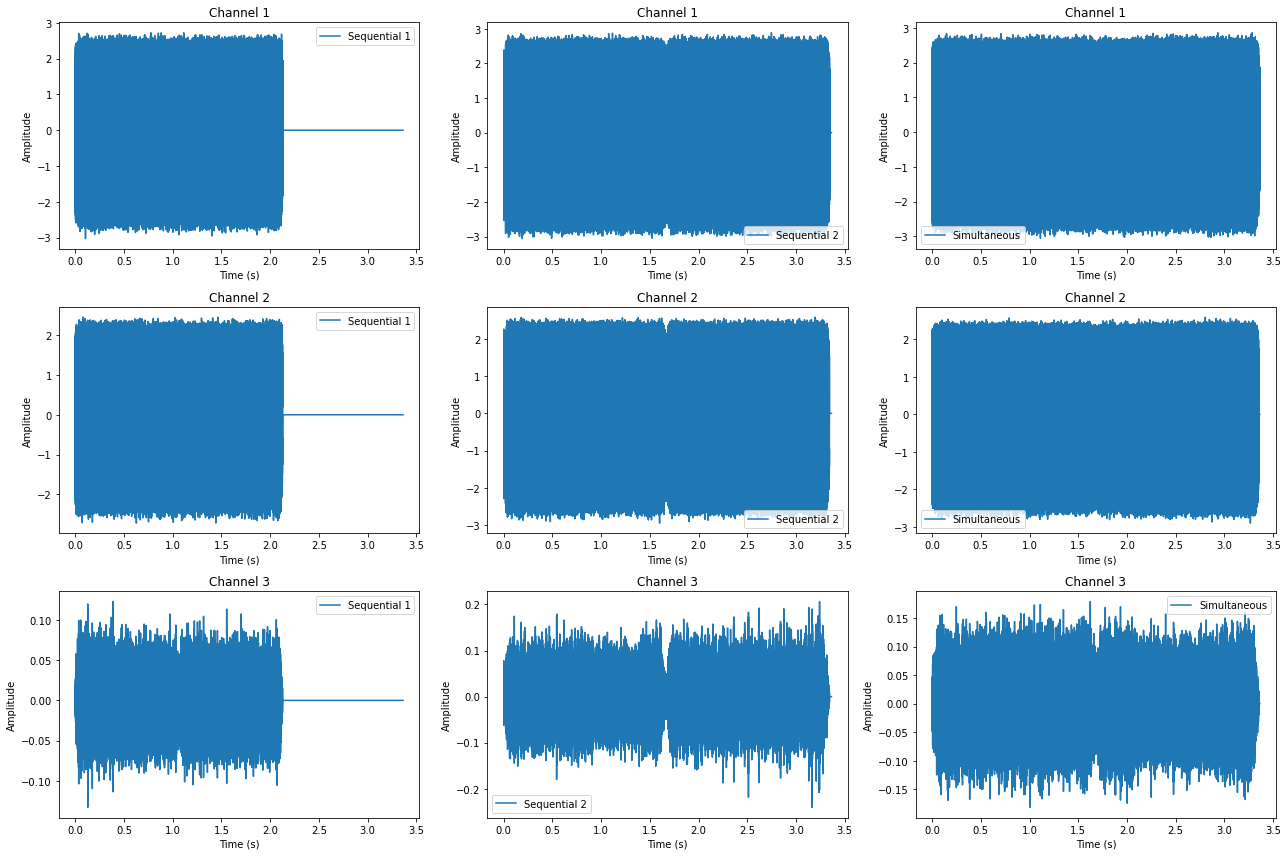

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Select a random key from the test_data
random_key = random.choice(list(test_data.keys()))

# Retrieve the data for the selected key
data = test_data[random_key]
sequential_data = data['sequential']
simultaneous_data = data['simultaneous']
mode = data['mode']

# Plot all channels for both sequential and simultaneous signals
# The structure is (2, num_channels, N) for sequential and (1, num_channels, N) for simultaneous

num_channels = sequential_data.shape[1]
N = sequential_data.shape[2]
time_vector = np.linspace(0, N / fs, N, endpoint=False)  # Sampling rate of 200kHz

# Create plots
fig, axs = plt.subplots(num_channels, 3, figsize=(18, 4 * num_channels))  # 3 plots per channel

for channel_idx in range(num_channels):
    # Plot sequential signals
    axs[channel_idx, 0].plot(time_vector, sequential_data[0, channel_idx, :].numpy(), label="Sequential 1")
    axs[channel_idx, 1].plot(time_vector, sequential_data[1, channel_idx, :].numpy(), label="Sequential 2")
    
    # Plot simultaneous signal
    axs[channel_idx, 2].plot(time_vector, simultaneous_data[0, channel_idx, :].numpy(), label="Simultaneous")
    
    for j in range(3):
        axs[channel_idx, j].set_title(f"Channel {channel_idx+1}")
        axs[channel_idx, j].legend()
        axs[channel_idx, j].set_xlabel("Time (s)")
        axs[channel_idx, j].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [4]:
def preload_data_to_cuda(train_data):
    preloaded_data = []
    file_names = []  # List to store file names
    for key, data in train_data.items():
        # Assuming 'simultaneous' and 'sequential' are the keys in your data dictionary
        simultaneous = data['simultaneous'].to(device)
        sequential = data['sequential'].to(device)
        preloaded_data.append((simultaneous, sequential))
        file_names.append(key)  # Store the file name (key) associated with this data
    return preloaded_data, file_names


In [5]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


In [6]:
# Initialize the model
filter_size = 5001  
model = AdaptiveFilter(input_channels=3, filter_size=filter_size)
model

AdaptiveFilter(
  (conv1): Conv1d(3, 64, kernel_size=(5001,), stride=(1,), padding=same)
  (prelu1): PReLU(num_parameters=1)
  (branch1_layers): ModuleList(
    (0-3): 4 x Conv1d(64, 64, kernel_size=(5001,), stride=(1,), padding=same)
  )
  (branch1_prelus): ModuleList(
    (0-3): 4 x PReLU(num_parameters=1)
  )
  (out1): Conv1d(64, 3, kernel_size=(5001,), stride=(1,), padding=same)
  (branch2_layers): ModuleList(
    (0-3): 4 x Conv1d(64, 64, kernel_size=(5001,), stride=(1,), padding=same)
  )
  (branch2_prelus): ModuleList(
    (0-3): 4 x PReLU(num_parameters=1)
  )
  (out2): Conv1d(64, 3, kernel_size=(5001,), stride=(1,), padding=same)
)

In [7]:
model.to(device)  # Ensure your model is on the correct device


AdaptiveFilter(
  (conv1): Conv1d(3, 64, kernel_size=(5001,), stride=(1,), padding=same)
  (prelu1): PReLU(num_parameters=1)
  (branch1_layers): ModuleList(
    (0-3): 4 x Conv1d(64, 64, kernel_size=(5001,), stride=(1,), padding=same)
  )
  (branch1_prelus): ModuleList(
    (0-3): 4 x PReLU(num_parameters=1)
  )
  (out1): Conv1d(64, 3, kernel_size=(5001,), stride=(1,), padding=same)
  (branch2_layers): ModuleList(
    (0-3): 4 x Conv1d(64, 64, kernel_size=(5001,), stride=(1,), padding=same)
  )
  (branch2_prelus): ModuleList(
    (0-3): 4 x PReLU(num_parameters=1)
  )
  (out2): Conv1d(64, 3, kernel_size=(5001,), stride=(1,), padding=same)
)

In [8]:
# Preload data to CUDA
preloaded_data, file_names = preload_data_to_cuda(train_data)


In [9]:
# Loss function
criterion = nn.MSELoss()


In [10]:
import random

def train_model_preloaded_lbfgs(model, criterion, preloaded_data, file_names, epochs=10, save_path='./Models'):
    model.train()
    # Setup LBFGS optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=1)

    # Combine data and filenames for access in closure
    combined_data = list(zip(preloaded_data, file_names))

    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            total_loss = 0.0

            # Process each item in the dataset
            for ((inputs, targets_seq), file_name) in combined_data:
                outputs_seq1, outputs_seq2 = model(inputs)
                loss1 = criterion(outputs_seq1, targets_seq.narrow(0, 0, 1))
                loss2 = criterion(outputs_seq2, targets_seq.narrow(0, 1, 1))
                loss = loss1 + loss2
                total_loss += loss.item()

                # Print the file name and individual losses for verbosity
                print(f"Processing {file_name}: Loss1 = {loss1.item():.4f}, Loss2 = {loss2.item():.4f}")

                # Backward to accumulate gradients, LBFGS will do the actual update
                loss.backward()
            
            return total_loss

        # Print epoch info and call optimizer step with closure
        print(f"Epoch {epoch+1} starting...")
        optimizer.step(closure)

        # Save the model at the end of each epoch
        epoch_save_path = f"{save_path}/model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), epoch_save_path)
        print(f"Model saved to {epoch_save_path}")

    print('Finished Training')


In [ ]:
# Training
train_model_preloaded_lbfgs(model, criterion, preloaded_data, file_names, epochs=100)

Epoch 1 starting...
Processing ('File_0', 'File_10'): Loss1 = 1.3546, Loss2 = 1.4094
Processing ('File_1', 'File_11'): Loss1 = 1.4158, Loss2 = 1.3255
Processing ('File_2', 'File_12'): Loss1 = 1.3697, Loss2 = 1.4347
Processing ('File_3', 'File_13'): Loss1 = 1.4231, Loss2 = 1.2973
Processing ('File_4', 'File_14'): Loss1 = 1.3756, Loss2 = 1.4122
Processing ('File_5', 'File_15'): Loss1 = 1.4174, Loss2 = 1.2722
Processing ('File_6', 'File_16'): Loss1 = 1.3663, Loss2 = 1.4047
Processing ('File_7', 'File_17'): Loss1 = 1.4145, Loss2 = 1.2660
Processing ('File_8', 'File_18'): Loss1 = 1.3559, Loss2 = 1.3902
Processing ('File_9', 'File_19'): Loss1 = 1.4098, Loss2 = 1.2515
Processing ('File_20', 'File_30'): Loss1 = 1.3496, Loss2 = 1.3908
Processing ('File_21', 'File_31'): Loss1 = 1.3959, Loss2 = 1.2516
Processing ('File_22', 'File_32'): Loss1 = 1.3448, Loss2 = 1.3835
Processing ('File_23', 'File_33'): Loss1 = 1.4005, Loss2 = 1.2555
Processing ('File_24', 'File_34'): Loss1 = 1.3461, Loss2 = 1.3836


Processing ('File_322', 'File_337'): Loss1 = 1.4828, Loss2 = 1.4923
Processing ('File_323', 'File_338'): Loss1 = 1.4675, Loss2 = 1.5299
Processing ('File_324', 'File_339'): Loss1 = 1.4859, Loss2 = 1.4965
Processing ('File_370', 'File_385'): Loss1 = 1.4928, Loss2 = 1.5026
Processing ('File_371', 'File_386'): Loss1 = 1.4751, Loss2 = 1.5318
Processing ('File_372', 'File_387'): Loss1 = 1.4894, Loss2 = 1.5041
Processing ('File_373', 'File_388'): Loss1 = 1.4824, Loss2 = 1.5338
Processing ('File_374', 'File_389'): Loss1 = 1.4880, Loss2 = 1.5020
Processing ('File_375', 'File_390'): Loss1 = 1.4812, Loss2 = 1.5328
Processing ('File_376', 'File_391'): Loss1 = 1.4952, Loss2 = 1.5045
Processing ('File_377', 'File_392'): Loss1 = 1.4818, Loss2 = 1.5319
Processing ('File_378', 'File_393'): Loss1 = 1.4886, Loss2 = 1.5038
Processing ('File_379', 'File_394'): Loss1 = 1.4822, Loss2 = 1.5369
Processing ('File_380', 'File_395'): Loss1 = 1.4921, Loss2 = 1.5050
Processing ('File_381', 'File_396'): Loss1 = 1.4

Processing ('File_289', 'File_304'): Loss1 = 1.4862, Loss2 = 0.7194
Processing ('File_290', 'File_305'): Loss1 = 1.5001, Loss2 = 0.8021
Processing ('File_291', 'File_306'): Loss1 = 1.4910, Loss2 = 0.7207
Processing ('File_292', 'File_307'): Loss1 = 1.5000, Loss2 = 0.8000
Processing ('File_293', 'File_308'): Loss1 = 1.4899, Loss2 = 0.7221
Processing ('File_294', 'File_309'): Loss1 = 1.4983, Loss2 = 0.7986
Processing ('File_310', 'File_325'): Loss1 = 1.4873, Loss2 = 1.3662
Processing ('File_311', 'File_326'): Loss1 = 1.4717, Loss2 = 1.4853
Processing ('File_312', 'File_327'): Loss1 = 1.4845, Loss2 = 1.4534
Processing ('File_313', 'File_328'): Loss1 = 1.4677, Loss2 = 1.5093
Processing ('File_314', 'File_329'): Loss1 = 1.4831, Loss2 = 1.4731
Processing ('File_315', 'File_330'): Loss1 = 1.4675, Loss2 = 1.5217
Processing ('File_316', 'File_331'): Loss1 = 1.4780, Loss2 = 1.4801
Processing ('File_317', 'File_332'): Loss1 = 1.4706, Loss2 = 1.5271
Processing ('File_318', 'File_333'): Loss1 = 1.4

In [ ]:
def evaluate_model(model, criterion, test_data):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for key, data in test_data.items():
            inputs = data['simultaneous'].to(device)
            targets_seq = data['sequential'].to(device)
            
            # Forward pass
            outputs_seq1, outputs_seq2 = model(inputs)
            loss = criterion(outputs_seq1, targets_seq.narrow(0,0,1)) + criterion(outputs_seq2, targets_seq.narrow(0,1,1))
            total_loss += loss.item()
    
    print(f"Test Loss: {total_loss / len(test_data)}")


In [ ]:
# Evaluation
evaluate_model(model, criterion, test_data)

In [ ]:
# Model parameters
input_channels = 1  # Assuming 1 channel input for simplicity; adjust as necessary
output_channels = 1  # Outputting 2 separate channels, but each is treated as 1-channel output
filter_size = 5  # Example filter size; adjust as per requirement

# Initialize the model
model = AdaptiveFilter(input_channels=input_channels, output_channels=output_channels, filter_size=filter_size)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
